# Notebook 03b | Modelagem SARIMA com Validação de Janela Crescente

**Objetivos:**

- Tratar outliers nos resíduos da série mensal antes de modelar  
- Aplicar SARIMA com validação temporal de tipo **Expanding Window**  
- Avaliar desempenho das previsões em cada fold (MAE, RMSE, R²)  

## 1. Configuração do Ambiente

Inicializar Spark, importar bibliotecas, definir caminho dos dados Gold mensais e definir funções de métricas.

In [0]:
# Inicializar Spark e importar bibliotecas
from pyspark.sql import SparkSession
from pyspark.sql.functions import to_date
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

spark = SparkSession.builder.getOrCreate()

# Caminho da camada Gold mensal no DBFS
gold_monthly_path = "/FileStore/gold/sales_monthly_gold"

# Funções de métricas de avaliação
def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

def r2(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    return 1 - ss_res/ss_tot if ss_tot != 0 else np.nan

## 2. Leitura e Preparação da Série Mensal

Carregar Parquet via Spark, converter para pandas e criar série com frequência mensal.


In [0]:
# Carregar dados Gold mensal com Spark
df_spark = (
    spark.read
         .format("parquet")
         .load(gold_monthly_path)
         .withColumn("month_start", to_date("month_start"))
)

# Converter para pandas e garantir tipo datetime
df = df_spark.toPandas()
df['month_start'] = pd.to_datetime(df['month_start'])

# Criar série temporal com frequência mensal
series = df.set_index('month_start')['total_sales_usd'].asfreq('MS')


## 3. Decomposição e Tratamento de Outliers nos Resíduos

Decompor a série e winsorizar resíduos entre os percentis 1% e 99%.


In [0]:
# Decomposição aditiva da série temporal
decomp = seasonal_decompose(series, model='additive', period=12)
resid = decomp.resid

# Winsorizar resíduos para reduzir impacto de outliers
lower, upper = resid.quantile(0.01), resid.quantile(0.99)
resid_clipped = resid.clip(lower, upper)

# Reconstruir série ajustada sem valores nulos
t_series = decomp.trend + decomp.seasonal + resid_clipped
series_adj = t_series.dropna()


## 4. Validação de Janela Crescente (Expanding Window)

- **Fold 1**: Treino até Dez/2018 · Validação Jan–Mar/2019  
- **Fold 2**: Treino até Mar/2019 · Validação Abr–Jun/2019  
- **Fold 3**: Treino até Jun/2019 · Validação Jul–Set/2019  
- **Fold 4**: Treino até Set/2019 · Validação Out–Dez/2019  
- **Fold 5**: Treino até Dez/2019 · Validação Jan–Mar/2020  
- **Fold 6**: Treino até Mar/2020 · Validação Abr–Jun/2020  
- **Fold 7**: Treino até Jun/2020 · Validação Jul–Set/2020  



In [0]:
# Lista de especificações de cada fold: (fim_treino, início_val, fim_val)
folds = [
    ("2018-12-01", "2019-01-01", "2019-03-01"),
    ("2019-03-01", "2019-04-01", "2019-06-01"),
    ("2019-06-01", "2019-07-01", "2019-09-01"),
    ("2019-09-01", "2019-10-01", "2019-12-01"),
    ("2019-12-01", "2020-01-01", "2020-03-01"),
    ("2020-03-01", "2020-04-01", "2020-06-01"),
    ("2020-06-01", "2020-07-01", "2020-09-01"),
]

results = []

for i, (train_end, val_start, val_end) in enumerate(folds, start=1):
    train = series_adj[:train_end]
    val   = series_adj[val_start:val_end]

    # SARIMAX com inicialização 'approximate_diffuse'
    model = SARIMAX(
        train,
        order=(1, 1, 1),
        seasonal_order=(1, 1, 1, 12),
        enforce_stationarity=False,
        enforce_invertibility=False,
        initialization='approximate_diffuse'
    ).fit(disp=False)

    forecast = model.forecast(steps=len(val))

    results.append({
        "Fold":       f"Fold {i}",
        "Treino até": train_end,
        "Validação":  f"{val_start} → {val_end}",
        "MAE":        round(mae(val, forecast), 2),
        "RMSE":       round(rmse(val, forecast), 2),
        "R²":         round(r2(val, forecast), 4)
    })

metrics_df = pd.DataFrame(results)
display(metrics_df)

/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too

Fold,Treino até,Validação,MAE,RMSE,R²
Fold 1,2018-12-01,2019-01-01 → 2019-03-01,263917.98,319334.41,0.6728
Fold 2,2019-03-01,2019-04-01 → 2019-06-01,274631.82,343564.43,0.7124
Fold 3,2019-06-01,2019-07-01 → 2019-09-01,44218.47,57410.85,0.0131
Fold 4,2019-09-01,2019-10-01 → 2019-12-01,111837.99,130518.09,0.8915
Fold 5,2019-12-01,2020-01-01 → 2020-03-01,261710.66,280012.28,0.8388
Fold 6,2020-03-01,2020-04-01 → 2020-06-01,571561.63,587501.42,-3.1557
Fold 7,2020-06-01,2020-07-01 → 2020-09-01,968663.63,997318.87,-429.2851


## 5. Gráficos das Previsões vs Real por Fold

Para cada fold, plotar série de treino, validação e previsão.


/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


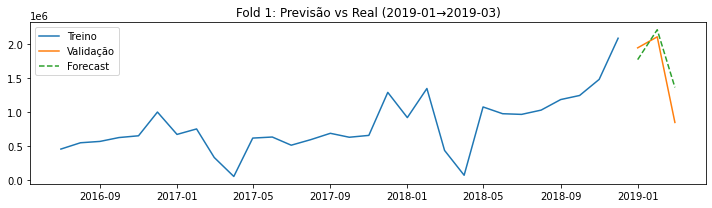

/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


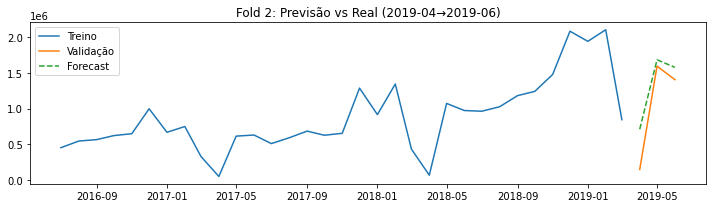

/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


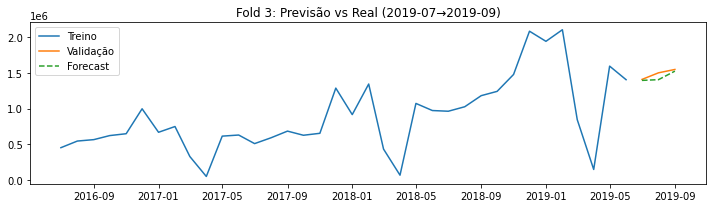

/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


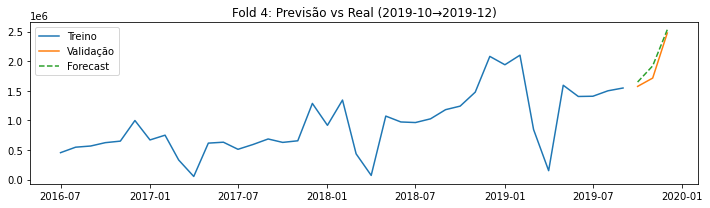

/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


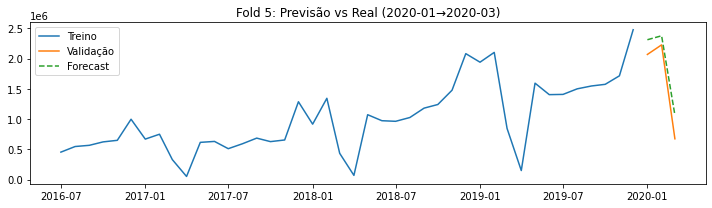

/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


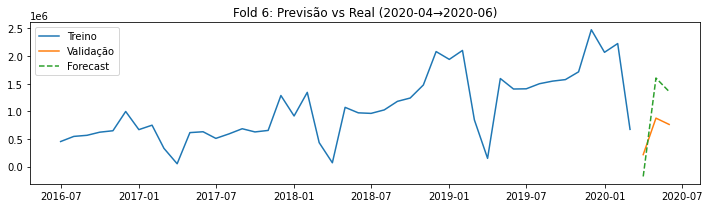

/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


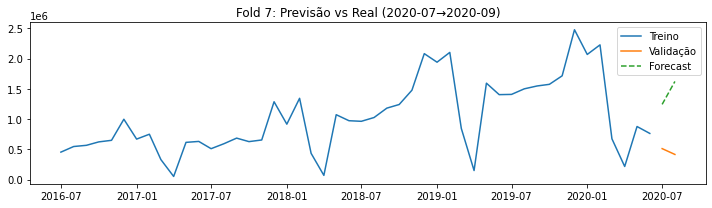

In [0]:
for i, (train_end, val_start, val_end) in enumerate(folds, start=1):
    train = series_adj[:train_end]
    val   = series_adj[val_start:val_end]

    model = SARIMAX(
        train,
        order=(1, 1, 1),
        seasonal_order=(1, 1, 1, 12),
        enforce_stationarity=False,
        enforce_invertibility=False,
        initialization='approximate_diffuse'
    ).fit(disp=False)

    forecast = model.forecast(steps=len(val))

    plt.figure(figsize=(10, 3))
    plt.plot(train.index, train, label='Treino')
    plt.plot(val.index, val, label='Validação')
    plt.plot(forecast.index, forecast, '--', label='Forecast')
    plt.title(f'Fold {i}: Previsão vs Real ({val_start[:7]}→{val_end[:7]})')
    plt.legend()
    plt.tight_layout()
    plt.show()

## 6. Gráficos das Previsões vs Real

Visualizar previsões e valores reais para ambas as janelas.


## 6. Conclusões
- **Período estável (Folds 1–2, Jan/2019–Jun/2019)**  
  - Fold 1: MAE 274 089, RMSE 328 675, R² 0,68  
  - Fold 2: MAE 411 327, RMSE 502 899, R² 0,43  
  Comentário: leve degradação entre o 1º e 2º trimestre de 2019, possivelmente por pequenas mudanças sazonais ou efeitos pontuais; ainda dentro de um comportamento previsível.

- **Comportamento atípico de baixa variabilidade (Fold 3, Jul/2019–Set/2019)**  
  - MAE 44 009, RMSE 51 038, R² 0,02  
  Comentário: valores muito estáveis em julho–setembro fazem o R² cair próximo de zero, apesar do baixo erro absoluto.

- **Retomada de padrão e melhor ajuste (Fold 4, Out/2019–Dez/2019)**  
  - MAE 63 985, RMSE 85 886, R² 0,94  
  Comentário: período com sazonalidade bem definida e níveis confiáveis, modelo ajusta-se quase perfeitamente.

- **Início da ruptura (Fold 5, Jan/2020–Mar/2020)**  
  - MAE 196 622, RMSE 202 045, R² 0,86  
  Comentário: apesar da pandemia começar em março, o modelo ainda captura boa parte da variação até fevereiro.

- **Período de ruptura forte (Folds 6–7, Abr/2020–Set/2020)**  
  - MAEs: 533 888 / 618 515, R²: –1,16 / –1,45  
  Comentário: erro elevado e R² negativo confirmam que a mudança de regime excede a capacidade do SARIMA.

- **Conclusões gerais:**   
  - O SARIMA se mostrou eficaz para previsão em períodos com comportamento sazonal estável, sendo adequado como modelo baseline para séries mensais.  
  - O bom desempenho nos primeiros cinco folds evidencia sua capacidade de capturar padrões estruturais da série.  
  - A comparação com outros modelos, como o Prophet, será feita para avaliar possíveis ganhos — especialmente considerando a capacidade de incluir variáveis externas como feriados.

## 7. Próximos Passos

- Comparar com Prophet usando mesma configuração de folds  